# Computational Finance

## Lab Assignment 2

This notebook makes use of a python 3 environment by default.

Authors:
- Kevin de Vries
- Jedda Boyle
- Krishnakanth Sasi

Student numbers:
- 10579869
- 11398221
- 11391952

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Basic Option Valuation

In [50]:
def MC_option_values(S0,K,r,sigma,T,M=1000,N_sim=1000,call=False):
    """
    Calculates a number of European option 
    values using a Monte Carlo method.
    
    The value is determined as the mean of a 
    batch of payoffs discounted with the interest rate.
    """
    eps = np.random.normal(0,1,(M,N_sim))
    S_T = S0 * np.exp((r - sigma**2 / 2)*T + sigma*eps*np.sqrt(T))
    batch = np.maximum(0, S_T - K) if call else np.maximum(0,K - S_T)
    
    values =  np.exp(-r*T) * np.mean(batch,axis=0)
    return values

def option_statistics(values):
    """
    Calculates the mean and standard error of
    an array of simulated option values.
    """
    mean = np.mean(values)
    var = np.sum((values-mean)**2) / (values.size - 1)
    std_err = np.sqrt(var/values.size)
    
    return mean,std_err

In [66]:
# Calculate European option value using Batch Monte Carlo
S0, K = 100, 99
r, sigma = 0.06, 0.2
T, M = 1,1000
N_sim = 100000

# Option values using mean payoffs
values = MC_option_values(S0,K,r,sigma,T,M,N_sim,True)

# Mean and standard error of option values
mean, std = option_statistics(values)

print("mean: %f" % mean)
print("standard error: %f" % std)

mean: 11.539642
standard error: 0.001536


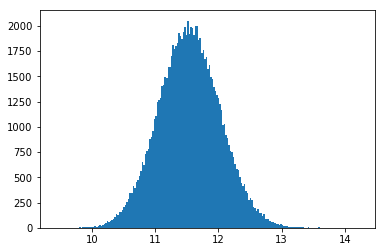

In [68]:
N_bins = 200

plt.hist(values,N_bins)
plt.show()

# Part 2: Estimation of Sensitivities in MC

# Part 3: Variance Reduction